In [ ]:
from zipfile import ZipFile

with ZipFile('/content/Huge_dataset.zip', 'r') as Zipobj:
    Zipobj.extractall("ECG_IMAGES_Huge_dataset")

In [1]:
from zipfile import ZipFile

with ZipFile('/content/preprocessed_ecg_images.zip', 'r') as Zipobj:
    Zipobj.extractall("preprocess")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filename = '/content/ECG_IMAGES_Huge_dataset/Huge_dataset/MI/MI(1).jpg'
img = mpimg.imread(filename)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filename = '/content/ECG_IMAGES_Huge_dataset/Huge_dataset/MI/MI(1).jpg'
img = mpimg.imread(filename)

print(f"Image size: {img.shape[0]} x {img.shape[1]}")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filename = '/content/ECG_IMAGES_Huge_dataset/Huge_dataset/MI/MI(1).jpg'
img = mpimg.imread(filename)


img_cropped = img[360:-80, :]


plt.imshow(img_cropped)
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color, filters, measure, morphology
from skimage.filters import threshold_otsu

filename = '/content/ECG_IMAGES_Huge_dataset/Huge_dataset/MI/MI(1).jpg'
img = mpimg.imread(filename)

img_cropped = img[360:-80, :]
grayscale = color.rgb2gray(img_cropped)
blurred_image = filters.gaussian(grayscale, sigma=0.7)
global_thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > global_thresh
plt.imshow(binary_image, cmap='gray')
plt.show()

In [ ]:
import os
import numpy as np
from skimage import io, color, filters
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

RAW_DIR = '/content/ECG_IMAGES_Huge_dataset/Huge_dataset'
PROCESSED_DIR = '/content/preprocess'


def process_images(source_dir, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)
    grayscale_dir = os.path.join(destination_dir, 'grayscale')
    os.makedirs(grayscale_dir, exist_ok=True)
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        dest_category_path = os.path.join(grayscale_dir, category)

        if os.path.isdir(category_path):
            os.makedirs(dest_category_path, exist_ok=True)

            for filename in os.listdir(category_path):
                file_path = os.path.join(category_path, filename)

                if os.path.isfile(file_path):
                    try:
                        img = io.imread(file_path)

                        img_cropped = img[360:-80, :]
                        grayscale_image = color.rgb2gray(img_cropped)
                        blurred_image = filters.gaussian(grayscale_image, sigma=0.7)
                        global_thresh = threshold_otsu(blurred_image)
                        binary_image = blurred_image > global_thresh
                        binary_image = (binary_image * 255).astype(np.uint8)
                        dest_file_path = os.path.join(dest_category_path, filename)
                        io.imsave(dest_file_path, binary_image)

                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")


print(f"Processing data from {RAW_DIR}...")
process_images(RAW_DIR, PROCESSED_DIR)
print("Processing completed.")


In [3]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape,
    Multiply, Flatten, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Squeeze Attention Module
def squeeze_attention_module(input_tensor):
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_avg = Dense(input_tensor.shape[-1], activation='relu')(channel_avg)
    channel_avg = Dense(input_tensor.shape[-1], activation='sigmoid')(channel_avg)
    channel_avg = Reshape((1, 1, input_tensor.shape[-1]))(channel_avg)
    return Multiply()([input_tensor, channel_avg])

# Squeeze Attention Network
def squeeze_attention_network(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_attention_module(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=predictions)

# Data Path
data_dir = '/content/preprocess/grayscale'

# Image Parameters
img_width, img_height = 224, 224
batch_size = 32
epochs = 12

# Load Data
file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file))
            labels.append(class_name)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Encode Labels
unique_classes = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_classes)}
index_to_label = {index: label for label, index in label_to_index.items()}  # Reverse mapping
labels = np.array([label_to_index[label] for label in labels])

# Train-Test Split
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# Convert Numeric Labels Back to Class Names
train_labels = [index_to_label[label] for label in train_labels]
test_labels = [index_to_label[label] for label in test_labels]

# Data Augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model Definition
model = squeeze_attention_network(input_shape=(img_width, img_height, 3), num_classes=len(unique_classes))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history =model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Evaluation (Final Accuracy Output Only)
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Found 963 validated image filenames belonging to 4 classes.
Found 413 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 496ms/step - accuracy: 0.2732 - loss: 3.3636 - val_accuracy: 0.2542 - val_loss: 1.3837
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step - accuracy: 0.3376 - loss: 1.3833 - val_accuracy: 0.2881 - val_loss: 1.3772
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - accuracy: 0.2753 - loss: 1.3825 - val_accuracy: 0.2881 - val_loss: 1.3791
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.2890 - loss: 1.3798 - val_accuracy: 0.2542 - val_loss: 1.3720
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.3043 - loss: 1.3564 - val_accuracy: 0.5472 - val_loss: 1.1224
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.5495 - loss: 1.0668 - val_accuracy: 0.7772 - val_loss: 0.5567
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.7802 - loss: 0.5837 - val_accuracy: 0.8765 - val_loss: 0.3530
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 411ms/step - accuracy: 0.9080 - loss: 0.2590 - val_accu

In [4]:

test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step


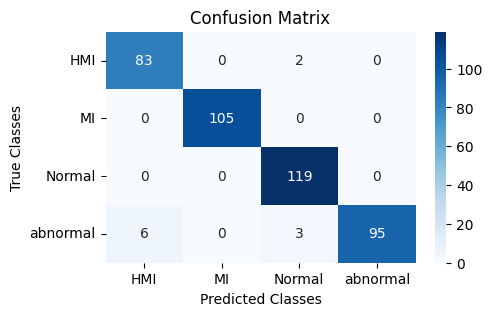

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [6]:

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

         HMI       0.93      0.98      0.95        85
          MI       1.00      1.00      1.00       105
      Normal       0.96      1.00      0.98       119
    abnormal       1.00      0.91      0.95       104

    accuracy                           0.97       413
   macro avg       0.97      0.97      0.97       413
weighted avg       0.97      0.97      0.97       413



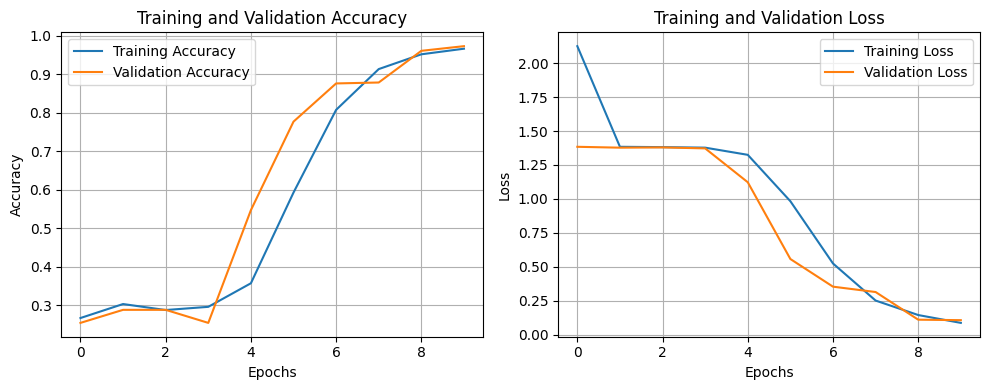

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.show()



In [10]:
history.model.save('large_data_training_model1.h5')

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color, filters
from skimage.filters import threshold_otsu
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model


model = load_model('large_data_training_model1.h5')


filename = '/content/HB(129).jpg'
img = mpimg.imread(filename)


img_cropped = img[360:-80, :]

grayscale = color.rgb2gray(img_cropped)
blurred_image = filters.gaussian(grayscale, sigma=0.7)

global_thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > global_thresh

preprocessed_image_path = '/content/preprocess_image.jpg'
plt.imsave(preprocessed_image_path, binary_image, cmap='gray')


def predict_image_class(image_path):

    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)


    img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)

    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    class_names = [ 'History of Myocardial Infarction', 'Myocardial Infarction', 'Normal', 'Abnormal']
    predicted_class = class_names[predicted_class_idx]

    return predicted_class

predicted_class = predict_image_class(preprocessed_image_path)
print(f"The predicted class of the image is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
The predicted class of the image is: Abnormal
